# Rhythm, Risk, Regression modelling
---

## Overview

This Notebook provides the background coding and data analysis to the Rhythm, Risk and Regression report.


## Import libraries needed


In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Import event data set (from SQL export)


In [3]:
tickets = pd.read_csv('v_events_and_artist_features.csv')

## Drop outlier events
These have been selected after producing the first linear regression model and can be commented out or added to as needed to see the effect.

In [4]:
tickets.drop(tickets[tickets['Event_ID'] == 1360160479609].index, inplace=True) #NoFlipe
tickets.drop(tickets[tickets['Event_ID'] == 702399575037].index, inplace=True) #GloryBe Workshop
tickets.drop(tickets[tickets['Event_ID'] == 196541830907].index, inplace=True) #Supergrass eve
tickets.drop(tickets[tickets['Event_ID'] == 196540426707].index, inplace=True) #Supergrass mtne
tickets.drop(tickets[tickets['Event_ID'] == 196564378347].index, inplace=True) #Cut capers
tickets.drop(tickets[tickets['Event_ID'] == 901381154297].index, inplace=True) #Pulp Matinee

tickets.drop(tickets[tickets['Event_ID'] == 175447266497].index, inplace=True) #Soul Destroyers TH
tickets.drop(tickets[tickets['Event_ID'] == 384665293247].index, inplace=True) #Gloryhole Sep 22
tickets.drop(tickets[tickets['Event_ID'] == 556460888497].index, inplace=True) #Elton John Matinee
tickets.drop(tickets[tickets['Event_ID'] == 446057549137].index, inplace=True) #Tankus


tickets.drop(tickets[tickets['Event_ID'] == 196579894757].index, inplace=True) #John Law Abbey
tickets.drop(tickets[tickets['Event_ID'] == 446042092907].index, inplace=True) #Instant Wit
tickets.drop(tickets[tickets['Event_ID'] == 196562923997].index, inplace=True) #Chris Wood
tickets.drop(tickets[tickets['Event_ID'] == 699069915937].index, inplace=True) #Frankesnteins Lobster
tickets.drop(tickets[tickets['Event_ID'] == 1219806487039].index, inplace=True) #ELP Matinee
tickets.drop(tickets[tickets['Event_ID'] == 397071640967].index, inplace=True) #Hags
tickets.drop(tickets[tickets['Event_ID'] == 397049123617].index, inplace=True) #Ben Ottewell

## Displaying for reference to feature names

In [5]:
tickets.head(5)

,Event_ID,Event_name,Event_format,Event_Capacity,Event_month,Event_performance,Event_Genre_ID,Event_Brand_ID,Event_avg_ticket_price,Event_location,Facebook_followers,Instagram_followers,YouTube_subscribers,Spotify_monthly_listeners,Tickets_Sold_y
0,1001246815177,Season Launch - Gloryhole Comedy Club presents…..,seated,80,10,evening,6,6,11.271,The Kings Arms,0,0,0,0,80
1,1003494147007,Malmesbury Acoustic Sessions presents Heidi Ta...,seated,80,11,evening,1,1,13.446,The Kings Arms,2263,2877,371,6585,51
2,1003500877137,The Blue Tone Sessions presents EscherSteps,seated,50,12,evening,2,2,11.477,Three Cups Inn,251,0,0,1,28
3,1003505089737,Malmesbury Acoustic Sessions presents Eddi Reader,seated,250,4,evening,1,1,27.105,Malmesbury Abbey,29000,1498,6070,53700,227
4,1003537867777,Gloryhole Comedy Club presents….,seated,80,1,evening,6,6,11.700,The Kings Arms,0,0,0,0,80


## Examine the relationship between the number of tickets sold and venue capacity

There is a linear correlation likely to skew the models which is also related to venue capacity. Need to be aware of this moving forward.

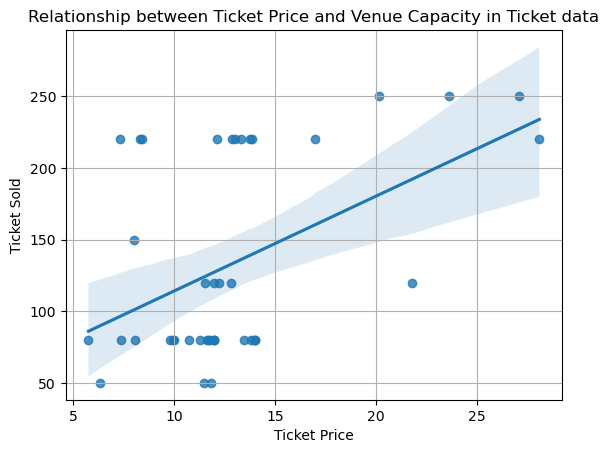

In [6]:
sns.regplot(data=tickets, x = 'Event_avg_ticket_price', y = 'Event_Capacity')
plt.grid()
plt.xlabel('Ticket Price')
plt.ylabel('Ticket Sold')
plt.title('Relationship between Ticket Price and Venue Capacity in Ticket data');

## Start by fitting a simple least squares (ols) model

This is v3 of the model which now has social media metrics added and venue capacity removed

In [7]:
#fit the ols model
model = smf.ols('Tickets_Sold_y ~ Facebook_followers + Instagram_followers + YouTube_subscribers + Spotify_monthly_listeners + C(Event_format) + C(Event_performance) + Event_avg_ticket_price + C(Event_month) + C(Event_Brand_ID) + C(Event_Genre_ID)', tickets).fit()
preds = model.predict(tickets[['Facebook_followers','Instagram_followers','YouTube_subscribers','Spotify_monthly_listeners','Event_format','Event_performance','Event_avg_ticket_price', 'Event_month','Event_Brand_ID','Event_Genre_ID']])

#model accuracy metrics
mse_model = mean_squared_error(tickets['Tickets_Sold_y'], preds)
rmse = np.sqrt(mse_model)
mae = mean_absolute_error(tickets['Tickets_Sold_y'], preds)

#print the results
print(f'The mse of ols model is {mse_model: .3f}')
print(f'The Rmse of ols model is {rmse: .3f}')
print(f'The MAE of ols model is {mae: .3f}')
print(f'against {len(preds)} events')
preds = model.predict(tickets[['Facebook_followers','Instagram_followers','YouTube_subscribers','Spotify_monthly_listeners','Event_format','Event_performance','Event_avg_ticket_price', 'Event_month','Event_Brand_ID','Event_Genre_ID']])


The mse of ols model is  159.951
The Rmse of ols model is  12.647
The MAE of ols model is  8.850
against 42 events


## Examine the residual on a histogram

This was used to identify outliers removed above to tune the model

(using seaborn as it's a nicer looking render for inclusion in the report)

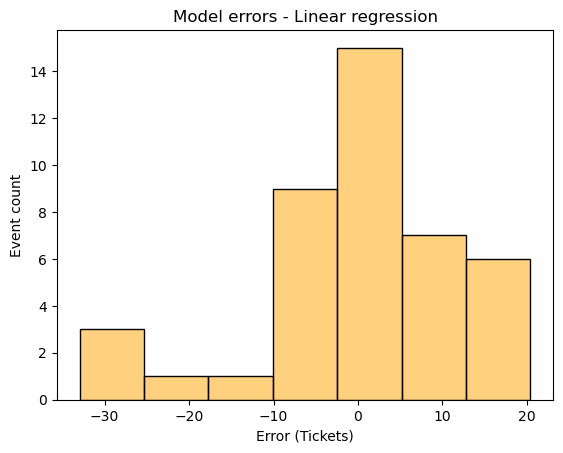

In [8]:
residuals = preds - tickets['Tickets_Sold_y']

sns_data = residuals.to_frame()
error_count_hist = sns.histplot(data=sns_data,palette=['orange'])
error_count_hist.get_legend().set_visible(False)

plt.xlabel("Error (Tickets)")
plt.ylabel("Event count")
plt.title("Model errors - Linear regression")
plt.savefig('linear_regression_errors.png')
plt.show(error_count_hist)

## Try a generalised (glm) model with different families to see if there is an improvement

Having tried all available fammilies, this is the best one using Poisson

In [9]:
#fit the glm model
model = smf.glm('Tickets_Sold_y ~ Facebook_followers + Instagram_followers + YouTube_subscribers + Spotify_monthly_listeners + C(Event_format) + C(Event_performance) + Event_avg_ticket_price + C(Event_month) + C(Event_Brand_ID) + C(Event_Genre_ID)', tickets,family=sm.families.Poisson()).fit()
preds = model.predict(tickets[['Facebook_followers','Instagram_followers','YouTube_subscribers','Spotify_monthly_listeners','Event_format','Event_performance','Event_avg_ticket_price', 'Event_month','Event_Brand_ID','Event_Genre_ID']])

#model accuracy metrics
mse_model = mean_squared_error(tickets['Tickets_Sold_y'], preds)
rmse = np.sqrt(mse_model)
mae = mean_absolute_error(tickets['Tickets_Sold_y'], preds)

#print the results
print(f'The mse of ols model is {mse_model: .3f}')
print(f'The Rmse of ols model is {rmse: .3f}')
print(f'The MAE of ols model is {mae: .3f}')
print(f'against {len(preds)} events')

The mse of ols model is  79.216
The Rmse of ols model is  8.900
The MAE of ols model is  6.763
against 42 events


### BETTER!

Take a look at the residuals ...

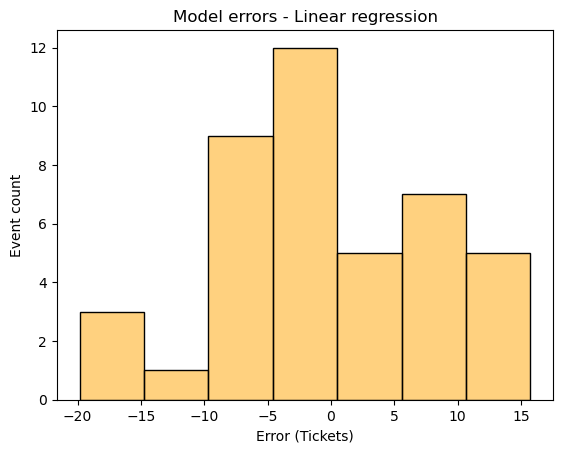

In [10]:
residuals = preds - tickets['Tickets_Sold_y']

sns_data = residuals.to_frame()
error_count_hist = sns.histplot(data=sns_data,palette=['orange'])
error_count_hist.get_legend().set_visible(False)

plt.xlabel("Error (Tickets)")
plt.ylabel("Event count")
plt.title("Model errors - Linear regression")
plt.savefig('linear_regression_errors.png')
plt.show(error_count_hist)

###### [Back to top](#Index:)

### This is looking good, and having tried some combinations, it tends to under estimated than over, which I like.

So creating a df of the residuals so see how the predictions feel against the actual events

Also want to include the greatest over and under predictions in the report

In [11]:
all_results = pd.DataFrame({'event':tickets['Event_ID'],'name':tickets['Event_name'],'Brand': tickets['Event_Brand_ID'], 'Predicted_Sales': preds.round(0),'Tickets_Sold': tickets['Tickets_Sold_y'],'dif':preds.round(0) - tickets['Tickets_Sold_y']})
all_results.sort_values(by=['dif'])

,event,name,Brand,Predicted_Sales,Tickets_Sold,dif
25,388637173247,Gloryhole Comedy Club (February 2023),6,60.000,80,-20.000
3,1003505089737,Malmesbury Acoustic Sessions presents Eddi Reader,1,208.000,227,-19.000
20,204988745857,The Blue Tone Sessions presents We Are Leif,2,35.000,51,-16.000
51,702457267597,Woodland Tales with Grandad,8,64.000,78,-14.000
46,701777213537,Jaz Delorean presented by Malmesbury Acoustic...,1,61.000,70,-9.000
45,701769129357,Theo May’s Odd Unit - Album launch - Present...,2,65.000,74,-9.000
31,429097631567,"Long Players - Madonna, True Blue (evening)",3,208.000,216,-8.000
44,699120647677,Gloryhole Comedy Club - December,6,65.000,73,-8.000
57,743518703457,The Long Players Go One Step Beyond (matinee -...,3,72.000,80,-8.000
23,384676215917,Gloryhole Comedy Club - Christmas Comedy,6,57.000,64,-7.000


### Now let's make some predictions with the model for new events

(I have a good idea of what these event should sell)

In [12]:
#noFlipe
new_data_noFlipe = pd.DataFrame({'Facebook_followers':[3800],'Instagram_followers':[1220],'YouTube_subscribers':[1080],'Spotify_monthly_listeners':[434],'Event_format':['standing'],'Event_performance':['evening'], 'Event_avg_ticket_price':[15], 'Event_month':[6],'Event_Brand_ID':[5],'Event_Genre_ID':[11]})
preds_noFlipe = model.predict(new_data_noFlipe)
print(f'The predicted ticket sales for the noFlipe event is {round(preds_noFlipe[0])} tickets')

#Will and Ludo
new_data_will_ludo = pd.DataFrame({'Facebook_followers':[742],'Instagram_followers':[116],'YouTube_subscribers':[331],'Spotify_monthly_listeners':[12],'Event_format':['seated'],'Event_performance':['evening'], 'Event_avg_ticket_price':[12.5], 'Event_month':[3],'Event_Brand_ID':[1],'Event_Genre_ID':[1]})
preds_will_ludo = model.predict(new_data_will_ludo)
print(f'The predicted ticket sales for the will_ludo event is {round(preds_will_ludo[0])} tickets')

#Philip Sheppard
new_data_ps = pd.DataFrame({'Facebook_followers':[1077],'Instagram_followers':[8129],'YouTube_subscribers':[484],'Spotify_monthly_listeners':[960853],'Event_format':['seated'],'Event_performance':['evening'], 'Event_avg_ticket_price':[18], 'Event_month':[1],'Event_Brand_ID':[7],'Event_Genre_ID':[7]})
preds_ps = model.predict(new_data_ps)
print(f'The predicted ticket sales for the _ps event is {round(preds_ps[0])} tickets')

#Poco Drom
new_data_pd = pd.DataFrame({'Facebook_followers':[5700],'Instagram_followers':[2534],'YouTube_subscribers':[1070],'Spotify_monthly_listeners':[154],'Event_format':['standing'],'Event_performance':['matinee'], 'Event_avg_ticket_price':[5], 'Event_month':[9],'Event_Brand_ID':[10],'Event_Genre_ID':[10]})
preds_pd = model.predict(new_data_pd)
print(f'The predicted ticket sales for the _pd event is {round(preds_pd[0])} tickets')

#Christmas comedy
new_data_cc = pd.DataFrame({'Facebook_followers':[0],'Instagram_followers':[0],'YouTube_subscribers':[0],'Spotify_monthly_listeners':[0],'Event_format':['seated'],'Event_performance':['evening'], 'Event_avg_ticket_price':[14], 'Event_month':[12],'Event_Brand_ID':[6],'Event_Genre_ID':[6]})
preds_cc = model.predict(new_data_cc)
print(f'The predicted ticket sales for the _cc event is {round(preds_cc[0])} tickets')


The predicted ticket sales for the noFlipe event is 117 tickets
The predicted ticket sales for the will_ludo event is 95 tickets
The predicted ticket sales for the _ps event is 205 tickets
The predicted ticket sales for the _pd event is 51 tickets
The predicted ticket sales for the _cc event is 76 tickets


### These seem reasonable. Let's try a new model - Polynomial Logistic Regression

Reload the data to reinstate dropped outliers

In [13]:
tickets = pd.read_csv('v_events_and_artist_features.csv')

In [15]:
# HAVING EXPERIMENTED I'VE DECIDED ON NO DROPS - model seems to be more acccurate with the full data set
# probably because it's using a train/test approach
#tickets.drop(tickets[tickets['Event_ID'] == 1360160479609].index, inplace=True) #NoFlipe
#tickets.drop(tickets[tickets['Event_ID'] == 901381154297 	].index, inplace=True) #Supergrass Matinee

In [16]:
#create training and test sets
X = tickets.drop(columns=['Event_ID','Event_name','Event_Capacity','Event_location','Tickets_Sold_y'], axis=1)
y = tickets['Tickets_Sold_y']

#using random_state = 22 excludes 'workshop' from the training data, so using 40
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=40)

X_train.head()

,Event_format,Event_month,Event_performance,Event_Genre_ID,Event_Brand_ID,Event_avg_ticket_price,Facebook_followers,Instagram_followers,YouTube_subscribers,Spotify_monthly_listeners
43,seated,12,evening,4,8,12.809,0,0,0,0
53,standing,11,evening,5,3,13.874,809000,147000,232000,4000000
0,seated,10,evening,6,6,11.271,0,0,0,0
26,standing,9,evening,13,11,8.000,0,4046,742,6996
21,standing,6,evening,11,5,17.000,155000,27700,48800,9488


### Transform categorical features

In [17]:
#Transform categorical features
transformer = make_column_transformer(
                                    (OneHotEncoder(sparse_output=False), ['Event_format','Event_month','Event_performance','Event_Genre_ID','Event_Brand_ID']),
                                     remainder = 'passthrough', 
                                     verbose=False)

X_train_transformed = transformer.fit_transform(X_train)
X_test_transformed = transformer.transform(X_test)

#show the first 2 rows of the transformed data
pd.DataFrame(X_train_transformed, columns = transformer.get_feature_names_out()).head(2)

,onehotencoder__Event_format_seated,onehotencoder__Event_format_standing,onehotencoder__Event_format_workshop,onehotencoder__Event_month_1,onehotencoder__Event_month_2,onehotencoder__Event_month_3,onehotencoder__Event_month_4,onehotencoder__Event_month_5,onehotencoder__Event_month_6,onehotencoder__Event_month_7,...,onehotencoder__Event_Brand_ID_6,onehotencoder__Event_Brand_ID_7,onehotencoder__Event_Brand_ID_8,onehotencoder__Event_Brand_ID_10,onehotencoder__Event_Brand_ID_11,remainder__Event_avg_ticket_price,remainder__Facebook_followers,remainder__Instagram_followers,remainder__YouTube_subscribers,remainder__Spotify_monthly_listeners
0,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,1.000,0.000,0.000,12.809,0.000,0.000,0.000,0.000
1,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,13.874,809000.000,147000.000,232000.000,4000000.000


### Build the model

All other solvers tried - lbfgs, newton-cg, newton-cholesky, sag, saga

liblinear works best

now tried with different degrees of complexity. (Anything above 3 takes a long time to run!)

In [18]:
train_error = []
test_error = []
for i in range(1, 4):
    pipe = make_pipeline(PolynomialFeatures(degree=i), LogisticRegression(solver='liblinear',max_iter=10000))
    pipe.fit(X_train_transformed, y_train)
    train_predictions = pipe.predict(X_train_transformed)
    test_predictions = pipe.predict(X_test_transformed)
    train_error.append(pipe.score(X_train_transformed, y_train))
    test_error.append(pipe.score(X_test_transformed, y_test))

    mse_model = mean_squared_error(y_train, train_predictions)
    rmse = np.sqrt(mse_model)
    mae = mean_absolute_error(y_train, train_predictions)
    
    
    print(f'Degree is {i}\nTrain Accuracy: {train_error[-1]: .4f}\nTest Accuracy: {test_error[-1]: .4f}\n')
    print(f'MSE: {mse_model: .4f}\nRMSE: {rmse: .4f}\nMAE: {mae: .4f}\n-----------')

Degree is 1
Train Accuracy:  0.4000
Test Accuracy:  0.1111

MSE:  3944.7400
RMSE:  62.8072
MAE:  34.5400
-----------
Degree is 2
Train Accuracy:  0.2600
Test Accuracy:  0.1111

MSE:  3420.9200
RMSE:  58.4886
MAE:  39.4400
-----------
Degree is 3
Train Accuracy:  0.2000
Test Accuracy:  0.0000

MSE:  8713.0000
RMSE:  93.3435
MAE:  73.6400
-----------


### On balance it looks like degree 2 is best with liblinear, but perhaps not as good as the Linear model. Continuing with this for now.

Rebuild the model with degree 2

In [52]:
pipe = make_pipeline(PolynomialFeatures(degree=2), LogisticRegression(solver='liblinear',max_iter=10000))
pipe.fit(X_train_transformed, y_train)
train_predictions = pipe.predict(X_train_transformed)
test_predictions = pipe.predict(X_test_transformed)
train_error.append(pipe.score(X_train_transformed, y_train))
test_error.append(pipe.score(X_test_transformed, y_test))

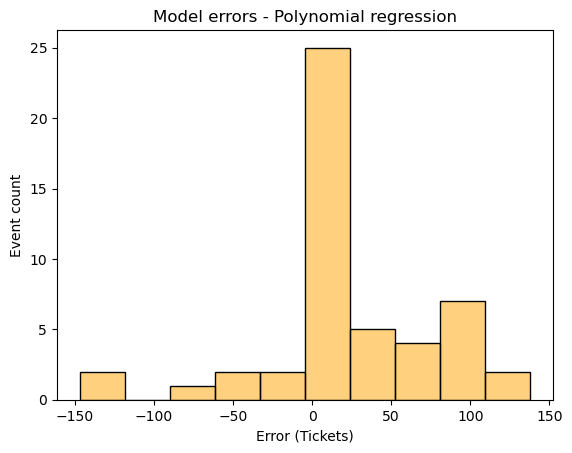

In [53]:
residuals = train_predictions - y_train
sns_data = residuals.to_frame()
error_count_hist = sns.histplot(data=sns_data,palette=['orange'])
error_count_hist.get_legend().set_visible(False)

plt.xlabel("Error (Tickets)")
plt.ylabel("Event count")
plt.title("Model errors - Polynomial regression")
plt.savefig('polymonial_regression_errors.png')
plt.show(error_count_hist)

In [54]:
# Run the model on the full data set
X_full_transformed = transformer.transform(X)

# Create predictions using the chosen model
final_predictions = pipe.predict(X_full_transformed)

# Create DF with actual, predicted, diff
comparison_df = pd.DataFrame({
    'Event_ID': tickets['Event_ID'].values,
    'Event_name': tickets['Event_name'].values,
    'Actual_Tickets_Sold': y.values,
    'Predicted_Tickets_Sold': final_predictions
})

# Add the diff
comparison_df['diff'] = comparison_df['Actual_Tickets_Sold'] - comparison_df['Predicted_Tickets_Sold']

# Sort by diff
comparison_df_sorted = comparison_df.sort_values(by='diff')

# Show events with predictions and errors
comparison_df_sorted

,Event_ID,Event_name,Actual_Tickets_Sold,Predicted_Tickets_Sold,diff
58,901381154297,Long Players are in a Different Class (matinee...,33,201,-168
9,1360160479609,MLA Season 4 Finale - With French Hip-Hop mast...,8,146,-138
2,1003500877137,The Blue Tone Sessions presents EscherSteps,28,146,-118
6,1003573584607,The Blue Tone Sessions presents Whiskey Moon Face,39,146,-107
30,397080688027,(A.N.t) Andy Nowak Trio,48,146,-98
20,204988745857,The Blue Tone Sessions presents We Are Leif,51,146,-95
40,699069915937,Season Launch Party with Frankenstein’s Lobster,51,146,-95
36,474763539527,Kevin Figes' Wallpaper Music II,54,146,-92
7,1219806487039,ELP (matinee - 3pm),131,220,-89
5,1003549913807,Famalam presents Poco Drom acoustic,58,146,-88


### Now try Decision trees

Reload the data

In [55]:
tickets = pd.read_csv('v_events_and_artist_features.csv')
tickets.head()

,Event_ID,Event_name,Event_format,Event_Capacity,Event_month,Event_performance,Event_Genre_ID,Event_Brand_ID,Event_avg_ticket_price,Event_location,Facebook_followers,Instagram_followers,YouTube_subscribers,Spotify_monthly_listeners,Tickets_Sold_y
0,1001246815177,Season Launch - Gloryhole Comedy Club presents…..,seated,80,10,evening,6,6,11.271,The Kings Arms,0,0,0,0,80
1,1003494147007,Malmesbury Acoustic Sessions presents Heidi Ta...,seated,80,11,evening,1,1,13.446,The Kings Arms,2263,2877,371,6585,51
2,1003500877137,The Blue Tone Sessions presents EscherSteps,seated,50,12,evening,2,2,11.477,Three Cups Inn,251,0,0,1,28
3,1003505089737,Malmesbury Acoustic Sessions presents Eddi Reader,seated,250,4,evening,1,1,27.105,Malmesbury Abbey,29000,1498,6070,53700,227
4,1003537867777,Gloryhole Comedy Club presents….,seated,80,1,evening,6,6,11.700,The Kings Arms,0,0,0,0,80


### Pull out the features I want and process categoricals

In [56]:
X = tickets.drop(['Event_ID','Event_name','Event_Capacity','Event_location','Tickets_Sold_y'], axis=1)
y = tickets['Tickets_Sold_y']

categorical_cols = list(X.select_dtypes(include="object").columns)
categorical_cols.append("Event_month")
categorical_cols.append("Event_Genre_ID")
categorical_cols.append("Event_Brand_ID")

preprocessor = make_column_transformer(
                                    (OneHotEncoder(sparse_output=False), categorical_cols),
                                     remainder = 'passthrough', 
                                     verbose=False,force_int_remainder_cols=False)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=40)

for i in range(1, 10):
    
    # Pipeline with Decision Tree
    model = make_pipeline(preprocessor,
        DecisionTreeRegressor(max_depth=i
                              , random_state=21)) #best depth = 6 - MSE 282

    model.fit(X_train, y_train)
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    y_pred = model.predict(X_test)
    
    print(f'\nAt depth {i}\n----------')
    print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}")
    print(f"R² Score: {r2_score(y_test, y_pred):.2f}")
    print(f"MAE Score: {mean_absolute_error(y_test, y_pred):.2f}")


At depth 1
----------
Mean Squared Error: 4008.74
R² Score: -1.28
MAE Score: 45.86

At depth 2
----------
Mean Squared Error: 2439.43
R² Score: -0.39
MAE Score: 32.70

At depth 3
----------
Mean Squared Error: 1945.69
R² Score: -0.10
MAE Score: 32.84

At depth 4
----------
Mean Squared Error: 426.92
R² Score: 0.76
MAE Score: 18.02

At depth 5
----------
Mean Squared Error: 1682.20
R² Score: 0.04
MAE Score: 30.72

At depth 6
----------
Mean Squared Error: 282.53
R² Score: 0.84
MAE Score: 12.96

At depth 7
----------
Mean Squared Error: 551.44
R² Score: 0.69
MAE Score: 17.33

At depth 8
----------
Mean Squared Error: 765.31
R² Score: 0.57
MAE Score: 17.52

At depth 9
----------
Mean Squared Error: 1087.67
R² Score: 0.38
MAE Score: 24.11


### Depth 6 is the best

### Rebuilt the Model at Depth 6

In [59]:
# Pipeline with Decision Tree

i = 6

model = make_pipeline(preprocessor,
    DecisionTreeRegressor(max_depth=i
                          , random_state=21)) #best depth = 6 - MSE 282

model.fit(X_train, y_train)
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

y_pred = model.predict(X_test)

print(f'\nAt depth {i}\n----------')
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")
print(f"MAE Score: {mean_absolute_error(y_test, y_pred):.2f}")


At depth 6
----------
Mean Squared Error: 282.53
R² Score: 0.84
MAE Score: 12.96


### Plot the errors

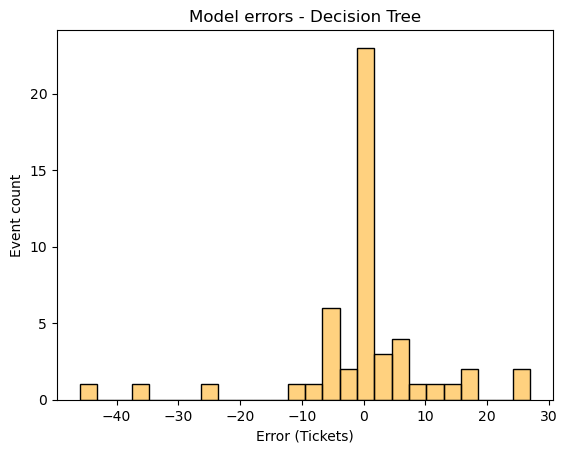

In [62]:
residuals = train_predictions - y_train
sns_data = residuals.to_frame()
error_count_hist = sns.histplot(data=sns_data,palette=['orange'])
error_count_hist.get_legend().set_visible(False)

plt.xlabel("Error (Tickets)")
plt.ylabel("Event count")
plt.title("Model errors - Decision Tree")
plt.savefig('decision_tree_errors.png')
plt.show(error_count_hist)

### Extract the predictions with each event to compare

In [65]:
preds = model.predict(tickets[['Facebook_followers','Instagram_followers','YouTube_subscribers','Spotify_monthly_listeners','Event_format','Event_performance','Event_avg_ticket_price', 'Event_month','Event_Brand_ID','Event_Genre_ID']])
all_results = pd.DataFrame({'event':tickets['Event_ID'],'name':tickets['Event_name'],'Brand': tickets['Event_Brand_ID'], 'Predicted_Sales': preds.round(0),'Tickets_Sold': tickets['Tickets_Sold_y'],'dif':preds.round(0) - tickets['Tickets_Sold_y']})

all_results.sort_values(by=['dif'])

,event,name,Brand,Predicted_Sales,Tickets_Sold,dif
48,701781225537,Poco Drom - Electro Pop-Punk Party for Mini Ra...,10,76.000,122,-46.000
15,196562923997,Malmesbury Acoustic Sessions Presents Chris Wo...,1,76.000,112,-36.000
29,397071640967,Hags by Scratchworks Theatre Company,8,76.000,106,-30.000
39,574631015837,Supermarine Music Presents Will Lawton and the...,1,76.000,102,-26.000
58,901381154297,Long Players are in a Different Class (matinee...,3,20.000,33,-13.000
36,474763539527,Kevin Figes' Wallpaper Music II,2,43.000,54,-11.000
28,397049123617,Ben Ottewell (Gomez),1,76.000,84,-8.000
20,204988745857,The Blue Tone Sessions presents We Are Leif,2,43.000,51,-8.000
4,1003537867777,Gloryhole Comedy Club presents….,6,74.000,80,-6.000
34,446042092907,Instant Wit - The Quick Fire Comedy Improvisat...,8,64.000,69,-5.000


### Conclusion

The best model from those tried is Generalised Linear Regression using the Posson family and with outliers removed from the data to produce predictions > -20 and < 20 from actuals. New example unseen events look to be producing reasonable predictions of tickets sales with a dendancy to underestimate rather than over estimate which is seen as a plus.